# SOUND SIGNAL CLASSIFICATION USING DEEP LEARNING

1. Adım Veri setimizi analiz için hazırlayacağız ve Mel-Frekans Cepstral Katsayılarını (MFCC) kullanarak ses dosyalarından ses sinyali özelliklerini çıkaracağız.

2. Daha sonra Convolutional Neural Networks  (CNN) modelini oluşturacağız ve modelimizi veri setimizle eğiteceğiz.

UrbanSound8K Veri Setini kullanacağız, indirme linki: https://urbansounddataset.weebly.com/download-urbansound8k.html

### Step 1: We will prepare our dataset for analysis and extract sound signal features from  audio files using Mel-Frequency Cepstral Coefficients(MFCC).

librosa kütüphanesini kullanarak veri setimizdeki her ses sinyalinin özelliklerini alacağız ve bunları bir listede tutacağız.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import librosa
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 



C:\Users\Damla\.conda\envs\tensorflow\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
#Librosa kullanarak örnek bir ses sinyali okuyalım
audio_file_path='17973-2-0-32.wav'

librosa_audio_data, librosa_sample_rate = librosa.load(audio_file_path)

In [4]:
#librosa okuduğu sesi dijital forma dönüştürecek
# bu mono sinyal formu üzerinden ses dosyanızın sinyal özelliklerini göstericek 
print(librosa_audio_data)

[ 0.05806023  0.04728271 -0.02169256 ... -0.00860656  0.03410248
  0.09018897]


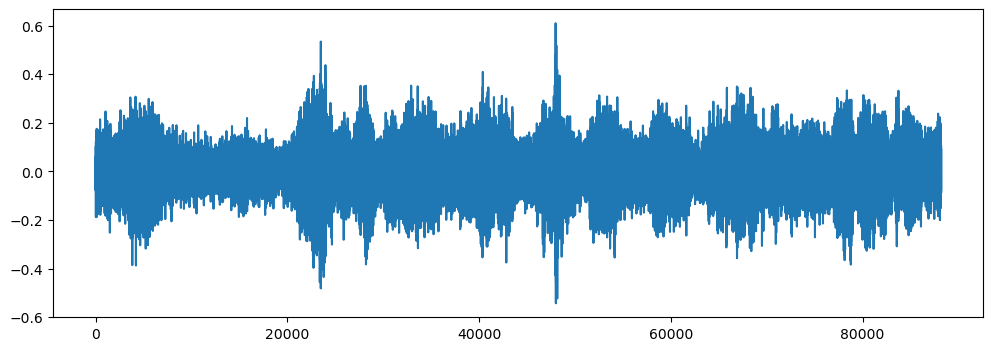

In [5]:
## Librosa örnek ses verisini çizelim
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)
plt.show()

### Feature Extraction
Burada ses örneklerinden Mel-Frekans Cepstral Katsayılarını (MFCC) kullanacağız. MFCC, pencere boyutu boyunca frekans dağılımını özetler, böylece sesin hem frekans hem de zaman özelliklerini analiz etmek mümkün olur. Bu ses temsilleri, sınıflandırma için özellikleri tanımlamamıza olanak sağlayacaktır.

In [6]:
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)   #n_mfcc:ses sinyalinden çıkarılacak öznitelik sayısı
print(mfccs.shape)

(40, 173)


Bu array değerleri ses sinyalinin  sınıflandırmak için kullanılacak değerleridir. 

In [7]:
mfccs  

array([[-167.09666  , -152.27574  , -172.7387   , ..., -192.53252  ,
        -179.42377  , -179.9042   ],
       [  77.15352  ,   94.49202  ,  109.3145   , ...,  107.66588  ,
          87.717316 ,   67.726715 ],
       [-108.97769  , -119.88193  , -128.7536   , ..., -112.772415 ,
         -98.41925  ,  -86.16422  ],
       ...,
       [  -9.484234 ,   -8.975718 ,  -14.132221 , ...,   -6.595039 ,
          -1.9226968,   -5.5306387],
       [   4.7791624,    3.693905 ,    5.1923394, ...,   -4.6435237,
         -12.0100975,  -17.334637 ],
       [   5.1541758,    7.4267035,    7.0431576, ...,   -2.6938493,
          -6.3918605,   -7.203297 ]], dtype=float32)

In [8]:
# Veri kümesindeki her ses dosyası için MFCC'leri çıkaracağız..

audio_dataset_path='UrbanSound8K/audio/'
metadata=pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [9]:
def features_extractor(filename):
    audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)  #scale işlemi
    
    return mfccs_scaled_features

In [10]:
# Artık her ses dosyasını yineliyoruz ve özellikleri çıkarıyoruz
# Mel-Frekans Cepstral Katsayılarını kullanma
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

3555it [08:50,  6.48it/s]C:\Users\Damla\.conda\envs\tensorflow\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)
8326it [20:17, 11.45it/s]C:\Users\Damla\.conda\envs\tensorflow\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1103
  return f(*args, **kwargs)
C:\Users\Damla\.conda\envs\tensorflow\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1523
  return f(*args, **kwargs)
8732it [21:13,  6.86it/s]


In [11]:
# # Çıkarılan_özellikleri Panda'nın dataframe  dönüştürüyoruz 2 sutuna feature ve class adını veriyoruz
extracted_features_df = pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-217.35526, 70.22338, -130.38527, -53.282898,...",dog_bark
1,"[-424.09818, 109.34077, -52.919525, 60.86475, ...",children_playing
2,"[-458.79114, 121.38419, -46.520657, 52.00812, ...",children_playing
3,"[-413.89984, 101.66373, -35.42945, 53.036354, ...",children_playing
4,"[-446.60352, 113.68541, -52.402206, 60.302044,...",children_playing


In [12]:
## Daha sonra veri setini bağımsız ve bağımlı veri setine bölüyoruz
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [13]:
#kaç satır ve sutundan oluştuğu gösterilecek. satırlar sınıflarımı sutunlar özniteliklerini içeriyor.
X.shape

(8732, 40)

In [14]:
X

array([[-2.1735526e+02,  7.0223381e+01, -1.3038527e+02, ...,
        -1.6930530e+00, -6.1698359e-01,  3.8600540e-01],
       [-4.2409818e+02,  1.0934077e+02, -5.2919525e+01, ...,
         5.3489321e-01, -5.4468733e-01,  4.4632089e-01],
       [-4.5879114e+02,  1.2138419e+02, -4.6520657e+01, ...,
         2.0768483e+00,  1.6962965e+00, -9.6140963e-01],
       ...,
       [-3.0388824e+02,  1.1135945e+02, -4.5941563e+01, ...,
        -3.0292380e+00,  2.7170298e+00,  7.6197419e+00],
       [-3.4411008e+02,  1.2545021e+02, -5.4903442e+01, ...,
        -7.9082437e+00, -1.6414586e+00,  5.6668444e+00],
       [-3.1560281e+02,  9.4854805e+01, -3.7222340e+01, ...,
         6.1386454e-01, -1.1449189e+01, -6.0105853e+00]], dtype=float32)

In [15]:
y

array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype='<U16')

In [16]:
y.shape

(8732,)

In [17]:
#y verilerini kategorik hale getiriyoruz. (0-1)
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [18]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [19]:
#Veri setini Train ve Test olarak ayırdık

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [20]:
X_train.shape

(6985, 40)

In [21]:
X_test.shape

(1747, 40)

In [22]:
y_train.shape

(6985, 10)

In [23]:
y_test.shape

(1747, 10)

### Step 2: Building a Convolutional Neural Networks (CNN) Model and Train Our Model with UrbanSound8K Dataset.


In [24]:
# 10 sınıfımız var  bunu kendi modelimizde kullanmalıyız
num_labels=10

In [25]:
#Şimdi CNN modelimizi oluşturmaya başlıyoruz eğitimimizde 3 hidden layer kullanıyoruz

model=Sequential()  # bu keras modeli katmanları sıralı bir şekilde eklemeyi sağlar.

# 1. hidden layer
model.add(Dense(125,input_shape=(40,))) #katmanı gizli katmandır bir önceki katmandaki her bir nöron, bu katmandaki her bir nörona bağlıdır
model.add(Activation('relu')) #aktivasyon fonk
model.add(Dropout(0.5)) #her bir eğitim iterasyonunda katmanın %50'sinin rastgele olarak atılacak
# 2. hidden layer
model.add(Dense(250)) #250 nöron
model.add(Activation('relu'))
model.add(Dropout(0.5))
# 3. hidden layer
model.add(Dense(125))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# output layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [26]:
model.summary() #model özeti

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 125)               5125      
_________________________________________________________________
activation (Activation)      (None, 125)               0         
_________________________________________________________________
dropout (Dropout)            (None, 125)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               31500     
_________________________________________________________________
activation_1 (Activation)    (None, 250)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 125)               3

In [27]:
#modelin eğitimi -derleme aşaması
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') # kayıp fonk-doğruluğu-optimizasyon algoritma

In [29]:
# Trianing the model

epochscount = 300  #veri seti üzerinden geçme sayısı
num_batch_size = 32 #eğitimde kullanılacak toplu işlem boyutu

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=epochscount, validation_data=(X_test, y_test), verbose=1)


Epoch 1/300
219/219 [==============================] - 1s 6ms/step - loss: 0.7227 - accuracy: 0.7658 - val_loss: 0.5656 - val_accuracy: 0.8266
Epoch 2/300
219/219 [==============================] - 1s 6ms/step - loss: 0.7152 - accuracy: 0.7664 - val_loss: 0.5668 - val_accuracy: 0.8266
Epoch 3/300
219/219 [==============================] - 1s 6ms/step - loss: 0.7244 - accuracy: 0.7651 - val_loss: 0.5911 - val_accuracy: 0.8185
Epoch 4/300
219/219 [==============================] - 1s 6ms/step - loss: 0.7178 - accuracy: 0.7635 - val_loss: 0.5599 - val_accuracy: 0.8351
Epoch 5/300
219/219 [==============================] - 1s 6ms/step - loss: 0.7070 - accuracy: 0.7691 - val_loss: 0.5687 - val_accuracy: 0.8237
Epoch 6/300
219/219 [==============================] - 1s 6ms/step - loss: 0.7341 - accuracy: 0.7648 - val_loss: 0.5815 - val_accuracy: 0.8260
Epoch 7/300
219/219 [==============================] - 1s 6ms/step - loss: 0.7269 - accuracy: 0.7644 - val_loss: 0.5746 - val_accuracy: 0.8185

In [30]:
validation_test_set_accuracy = model.evaluate(X_test,y_test,verbose=0)
print(validation_test_set_accuracy[1]) #modelin test veri seti üzerinden elde edilen doğruluk değeri

0.829994261264801


### Step 3: Finally We Predict an Audio File's Class Using Our CNN Model.

We first preprocess the new audio data and then predict the class.


In [1]:
filename="PoliceSiren.wav"
sound_signal, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=sound_signal, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

NameError: name 'librosa' is not defined

In [38]:
mfccs_scaled_features = mfccs_scaled_features.reshape(1,-1)

In [39]:
mfccs_scaled_features.shape #1 satır 40 sutunluk

(1, 40)

In [40]:
result_array = model.predict(mfccs_scaled_features)

In [41]:
result_array

array([[0.01031649, 0.00709846, 0.576709  , 0.13886659, 0.06766428,
        0.01844493, 0.09245314, 0.00314256, 0.03112269, 0.05418186]],
      dtype=float32)

In [42]:
result_classes = ["air_conditioner","car_horn","children_playing","dog_bark","drilling", "engine_idling", "gun_shot", "jackhammer", "siren", "street_music"]

result = np.argmax(result_array[0])
print(result_classes[result]) 

children_playing
